# **Course: Image Processing and Applications (CS406.Q11)**
**Group ID - Group Name:** 9 - Thăng Sắc 

**Member:** 
- Nguyen Cong Phat - 23521143 (Leader)
- Nguyen Xuan An - 23520023
- Truong Hoang Thanh An - 23520032
- Vu Viet Cuong - 23520213
### **Evaluate Models** 

 
**Dataset:** FLAME (semantic segmentation)


## **1. Environment & Imports**

In [1]:
import os
import torch
import numpy as np
from torch import nn
import segmentation_models_pytorch as smp
import cv2
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torch.optim import lr_scheduler
from IPython.display import Image
from natsort import os_sorted

/home/sakocpo/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sakocpo/miniconda3/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## **2. Dataset Class**

In [2]:
class FlameDataset(Dataset):
    def __init__(self, img_dir,mask_dir,transform=None):
        self.img_dir=img_dir
        self.mask_dir=mask_dir
        self.transform=transform
        self.image_filenames = os_sorted(os.listdir(img_dir))
        self.mask_filenames = os_sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir,self.image_filenames[index])
        mask_path = os.path.join(self.mask_dir,self.mask_filenames[index])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path,0)
        mask = (mask>0).astype(np.uint8)

        if self.transform:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
        image = np.transpose(image, (2, 0, 1))
    
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

## **3. Dataset & DataLoader**

In [ ]:
DATA_ROOT = "/mnt/d/flame-dataset"

transform = A.Compose(
    [
        A.Resize(width=512,height=512)
    ]
)
train_dataset = FlameDataset(img_dir=f'{DATA_ROOT}/train/images',mask_dir=f'{DATA_ROOT}/train/masks',transform=transform)
val_dataset = FlameDataset(img_dir=f'{DATA_ROOT}/val/images',mask_dir=f'{DATA_ROOT}/val/masks',transform=transform)
test_dataset = FlameDataset(img_dir=f'{DATA_ROOT}/test/images',mask_dir=f'{DATA_ROOT}/test/masks',transform=transform)

In [4]:
LR=0.001
BATCH_SIZE=4
DECAY=0.00001
MOMENTUM=0.9
NUM_WORKERS=8
EPOCHS=50

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,drop_last=True)

In [6]:
len(train_dataloader),len(val_dataloader),len(test_dataloader)

(300, 100, 100)

## **4. VISUALIZE SAMPLE DATASET**

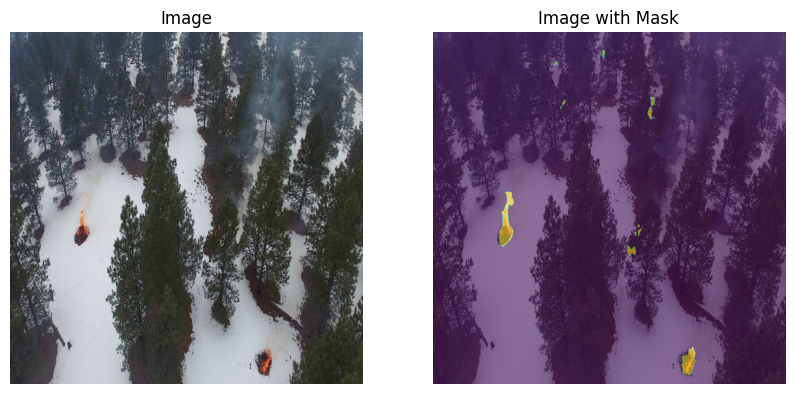

In [8]:
sample = test_dataset[154]  

image = sample[0].numpy().transpose(1, 2, 0) #(C, H, W) -> (H, W, C)
mask = sample[1].numpy()  

plt.figure(figsize=(10, 8))


plt.subplot(1, 2, 1)
plt.imshow(image.astype(np.uint8))  
plt.title("Image")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(image.astype(np.uint8)) 
plt.imshow(mask, alpha=0.5)  
plt.title("Image with Mask")
plt.axis("off")

plt.show()


## **5. Lightning Model (UNet)**

In [17]:
class FlameModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
    def forward(self, x):
        x = (x - self.mean) / self.std
        return self.model(x)

## **7. Evaluate**

In [ ]:
model_bce = FlameModel.load_from_checkpoint(
    arch="unet",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
    num_loss=1,
    checkpoint_path="/mnt/d/models/Unet_r34_bce.ckpt"
)

model_bce_aug = FlameModel.load_from_checkpoint(
    arch="unet",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
    num_loss=1,
    checkpoint_path="/mnt/d/models/Unet_r34_bce_aug.ckpt"
)

model_3loss = FlameModel.load_from_checkpoint(
    arch="unet",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
    num_loss=3,
    checkpoint_path="/mnt/d/models/Unet_r34_3loss.ckpt"
)

model_3loss_aug = FlameModel.load_from_checkpoint(
    arch="unet",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
    num_loss=3,
    checkpoint_path="/mnt/d/models/Unet_r34_512_all.ckpt"
)

In [19]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
test_metrics = []
model_list = [model_bce,model_bce_aug,model_3loss,model_3loss_aug]

for model in model_list:
    test_metric = trainer.test(model,dataloaders=test_dataloader,verbose=True)
    test_metrics.append(test_metric)
    print(test_metric)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_accuracy:       │     0.997821569442749     │
│       test_f2_score       │    0.7228431105613708     │
│         test_iou          │    0.6396613717079163     │
│      test_precision:      │    0.8992325663566589     │
│       test_recall:        │    0.6890527009963989     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'test_iou': 0.6396613717079163, 'test_f2_score': 0.7228431105613708, 'test_accuracy:': 0.997821569442749, 'test_precision:': 0.8992325663566589, 'test_recall:': 0.6890527009963989}]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_accuracy:       │    0.9981334209442139     │
│       test_f2_score       │    0.7672237753868103     │
│         test_iou          │    0.6892729997634888     │
│      test_precision:      │    0.9129050970077515     │
│       test_recall:        │    0.7377896308898926     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'test_iou': 0.6892729997634888, 'test_f2_score': 0.7672237753868103, 'test_accuracy:': 0.9981334209442139, 'test_precision:': 0.9129050970077515, 'test_recall:': 0.7377896308898926}]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  0.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_accuracy:       │    0.9980617165565491     │
│       test_f2_score       │    0.7740764021873474     │
│         test_iou          │    0.6847550868988037     │
│      test_precision:      │    0.8869982361793518     │
│       test_recall:        │    0.7501998543739319     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'test_iou': 0.6847550868988037, 'test_f2_score': 0.7740764021873474, 'test_accuracy:': 0.9980617165565491, 'test_precision:': 0.8869982361793518, 'test_recall:': 0.7501998543739319}]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_accuracy:       │    0.9981892704963684     │
│       test_f2_score       │    0.8162868022918701     │
│         test_iou          │     0.713983416557312     │
│      test_precision:      │    0.8627946972846985     │
│       test_recall:        │    0.8054327964782715     │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.713983416557312, 'test_f2_score': 0.8162868022918701, 'test_accuracy:': 0.9981892704963684, 'test_precision:': 0.8627946972846985, 'test_recall:': 0.8054327964782715}]
